In [1]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import pandas as pd
import warnings 
warnings.simplefilter('ignore')
import seaborn as sns
from sklearn import metrics
from sklearn import decomposition
from sklearn.preprocessing import normalize
from scipy.stats import ks_2samp
import scipy.io as sio
import os
import importlib
import rutils
import xarray as xr
from pyaldata import *
from rutils import *

'''
Plotting aesthetics
'''
sns.set_style('white')
sns.set_context('notebook', font_scale=1.35)

cmap = sns.light_palette(color='#314ac0', as_cmap=True)
div_cmap = sns.diverging_palette(250, 150, as_cmap=True)

cs = ['#314ac0', '#ef3737', '#5ae09e', '#EBE12E', '#3D7E43', '#2D2F39', '#4D7399', '#CDBCA5']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)

'''
Magic commands
'''
%load_ext autoreload
%autoreload 5
%config InlineBackend.figure_format = 'retina'

---

### Systematic checks

**General**

- [x] Use the same session (`'2016-09-09'`)
- [ ] Go through Matt code step by step and use exactly the same parameters

**Preprocessing**

1. [x] Combine time bins with `n_bins=3`
2. [ ] Remove low firing neurons with `threshold=5` $\to$ how many neurons are removed? Matt has >200 neurons prior to doing PCA.
3. [x] Transform signal with sqrt `params=?` 
4. [ ] Smooth signals with `std = {0.01, 0.05}`
5. [ ] Restrict to time interval? 
6. [ ] Remove cross-condition mean?

**Methods**

- [x] Sanity check `read_cmp()`
- [x] Sanity check `localize_elecs()`
- [x] Sanity check `getPCA()` and rewrite this function $\to$ consider removing it
- [x] Sanity check `sort_pcs_by()` $\to$ now called `sort_pcs()` checked multiple times and this should be correct now 
- [x] Sanity check `compare_self_glob_mani()` $\to$ Done, this must be correct
- [ ] Sanity check `compare_pc_weights()`
 
---

## Load session and transform to dataframe

In [49]:
file = '/Users/Daphne/Data/Chewie_CO_VR_2016-09-09.mat'  # file matt used to generate initial figures in matlab
df = mat2dataframe(file, shift_idx_fields=True)

In [90]:
#df.head()

In [51]:
df.shape

(877, 24)

In [52]:
df.M1_spikes[0].shape

(295, 55)

In [53]:
df.PMd_spikes[0].shape

(295, 191)

## 1 Preprocess

In [73]:
# Combine bins 
td = combine_time_bins(df, n_bins=3)

# Remove low firing neurons
td = remove_low_firing_neurons(td, signal='M1_spikes',  threshold=1)
td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=1)

# Sqrt transform neurons
td = transform_signal(td, signal='M1_spikes',  transformations='sqrt')
td = transform_signal(td, signal='PMd_spikes', transformations='sqrt')

# Merge signals
td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

# Calculate firing rates from spikes, works on '_spikes' fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth', std=0.05)

print(f'Total neurons before processing: {df.M1_spikes[0].shape[1]+ df.PMd_spikes[0].shape[1]}\n')
print(f'Total neurons after preprocessing: {td.M1_spikes[0].shape[1]+ td.PMd_spikes[0].shape[1]}')

Total neurons before processing: 246

Total neurons after preprocessing: 218


This is what `add_firing_rates()` does to the spike counts.

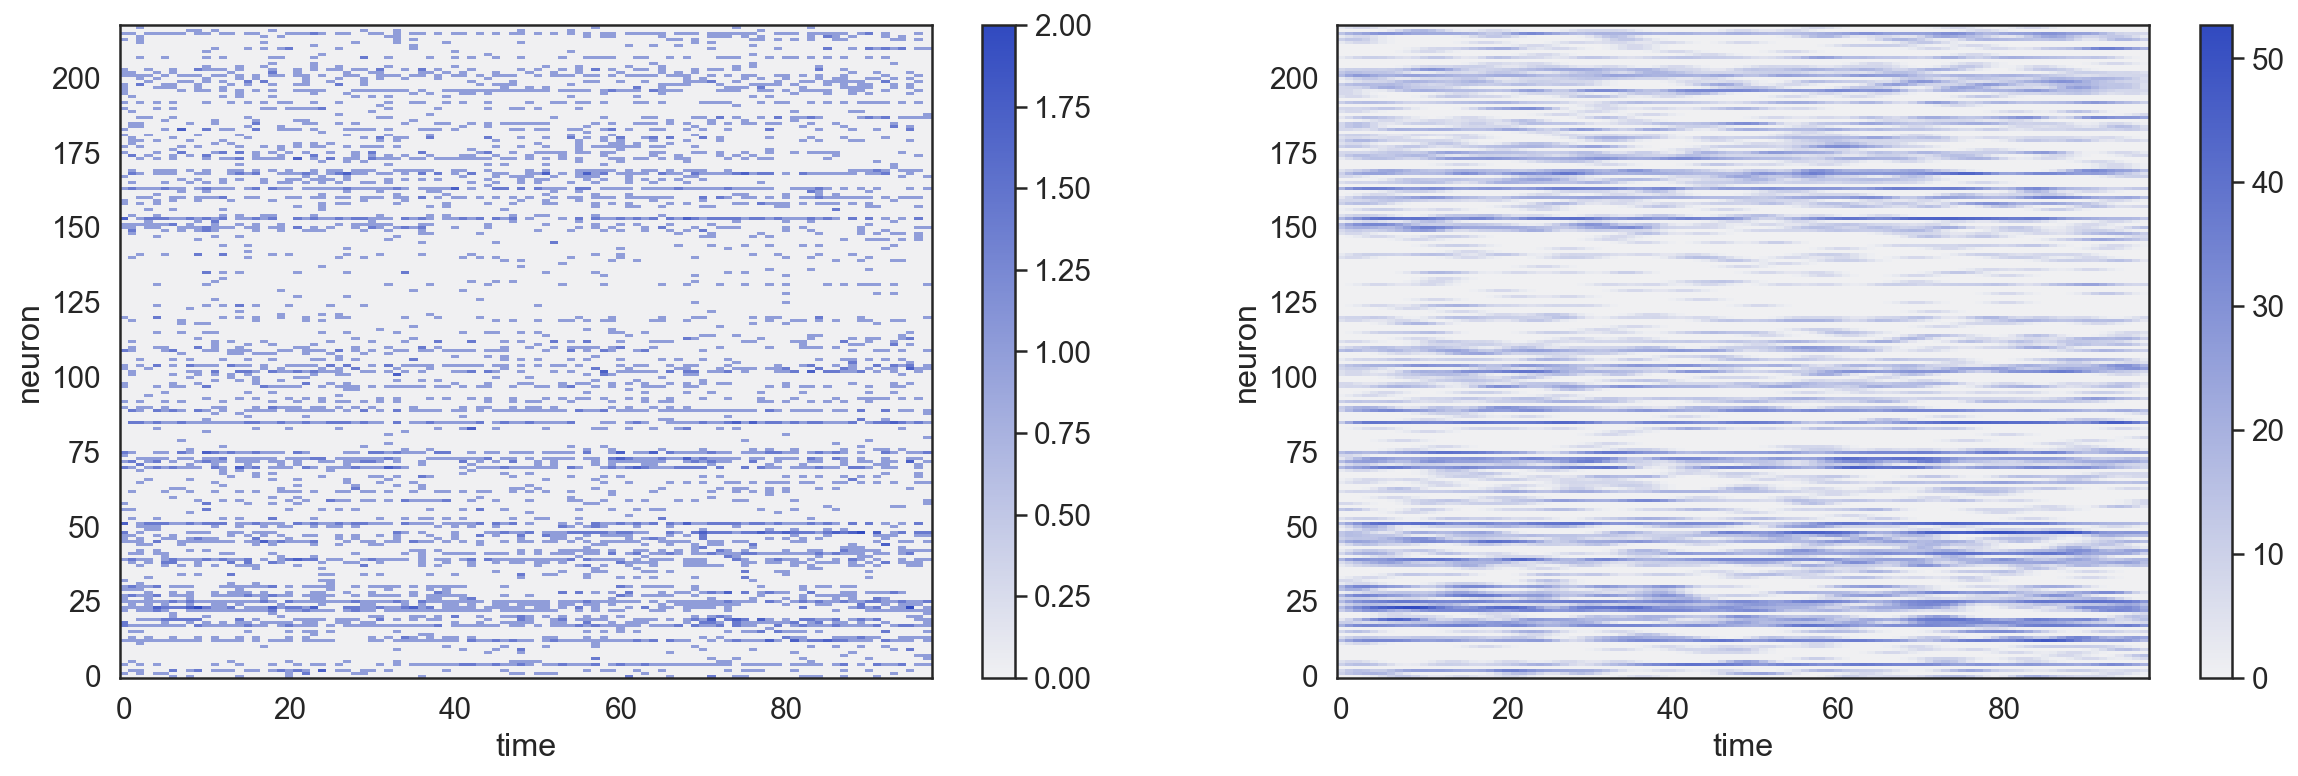

In [74]:
fig, ax = plt.subplots(figsize=(20, 6), ncols=2)

xr.DataArray(td.both_spikes[0], dims = ['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[0], cmap=cmap)
xr.DataArray(td.both_rates[0],  dims = ['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[1], cmap=cmap);

In [75]:
td.M1_spikes[0].shape, td.M1_rates[0].shape # timepoints x neurons

((98, 51), (98, 51))

In [76]:
td.PMd_spikes[0].shape, td.PMd_rates[0].shape

((98, 167), (98, 167))

In [77]:
td.both_spikes[0].shape, td.both_rates[0].shape

((98, 218), (98, 218))

## 2 Dimensionality reduction

### 2.1 Perform PCA on both arrays

We have 877 trials and a total of 111 neurons.

We perform PCA on the computed firing rates.

PCA uses the SVD to project the data to a lower dimensional space (in sklearn).

\begin{align} 
\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T  
\end{align}

where

- $\mathbf{X}$ is the neural firing data of size neurons by timepoints: $N \times T$
- $\mathbf{U}$ is the left singular vectors matrix of size $N \times N$
- $\mathbf{\Sigma}$ is the (diagonal) singular *values* matrix of size $N \times T$
- $\mathbf{V}$ is the right singular vectors matrix of size $N \times N$

In [78]:
from sklearn.decomposition import PCA

In [79]:
# we want to get a pc for all neurons
pca_dims = td.both_rates[0].shape[1]

# perform dimensionality reduction on all trialdata
td, model_m1pmd = tools.dim_reduce(td, PCA(pca_dims), 'both_rates', 'both_pca', return_model=True)

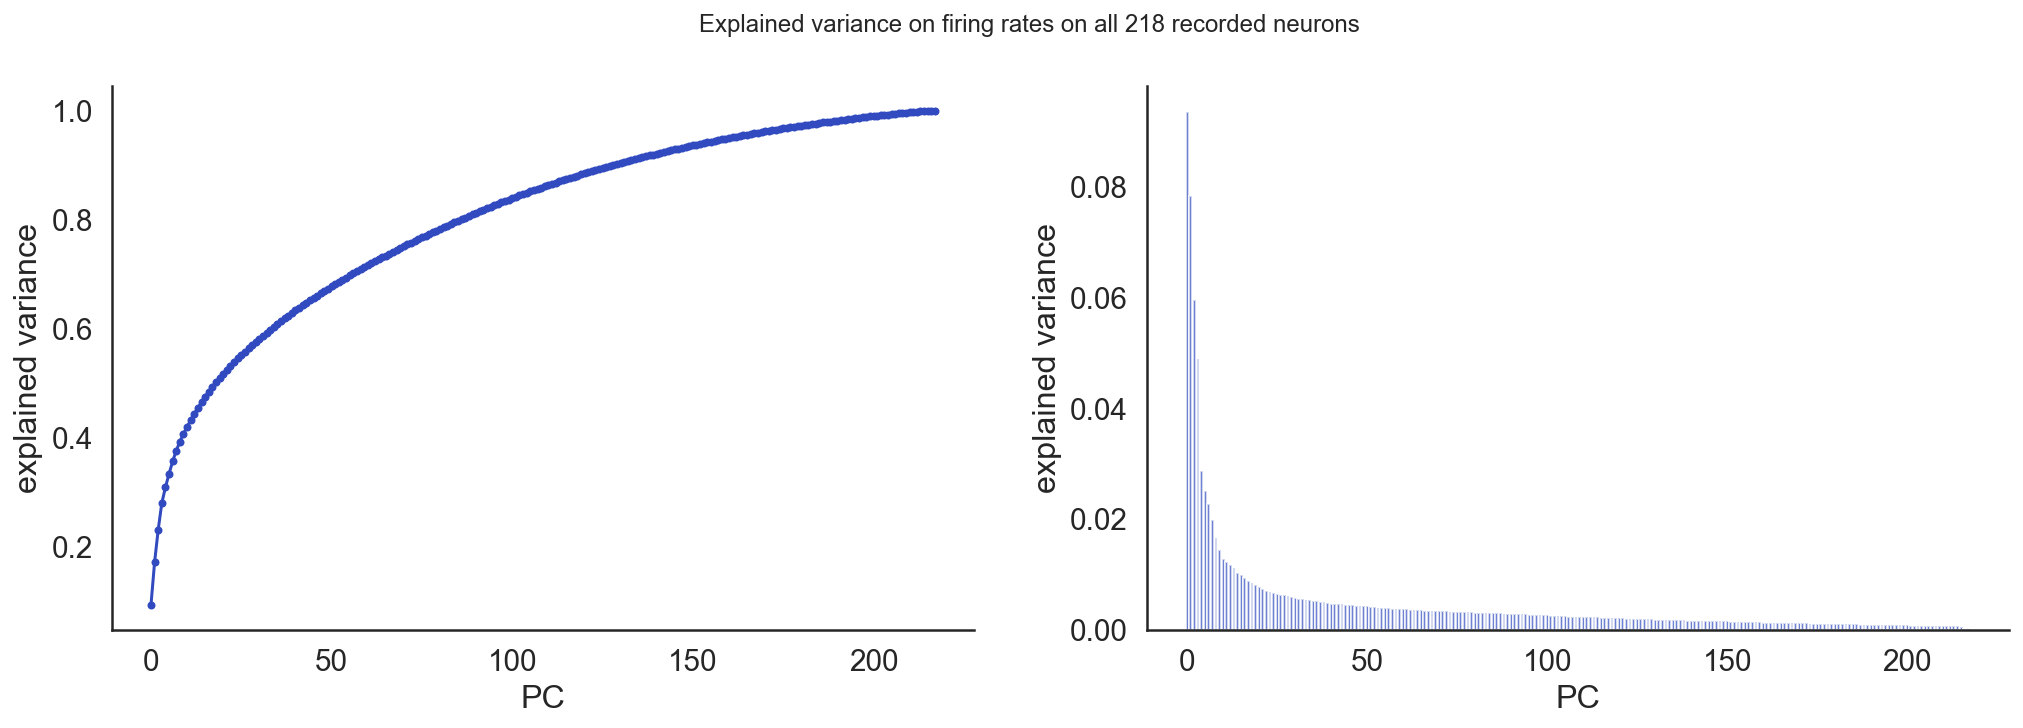

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
fig.suptitle(f'Explained variance on firing rates on all {td.both_rates[0].shape[1]} recorded neurons')
ax1.plot(model_m1pmd.explained_variance_ratio_.cumsum(), '.-')
ax1.set_xlabel('PC')
ax1.set_ylabel('explained variance')

ax2.bar(range(len(model_m1pmd.explained_variance_ratio_)), model_m1pmd.explained_variance_ratio_, alpha=0.7, align='center')
ax2.set_xlabel('PC')
ax2.set_ylabel('explained variance')
sns.despine()

In [81]:
model_m1pmd.components_.shape 

(218, 218)

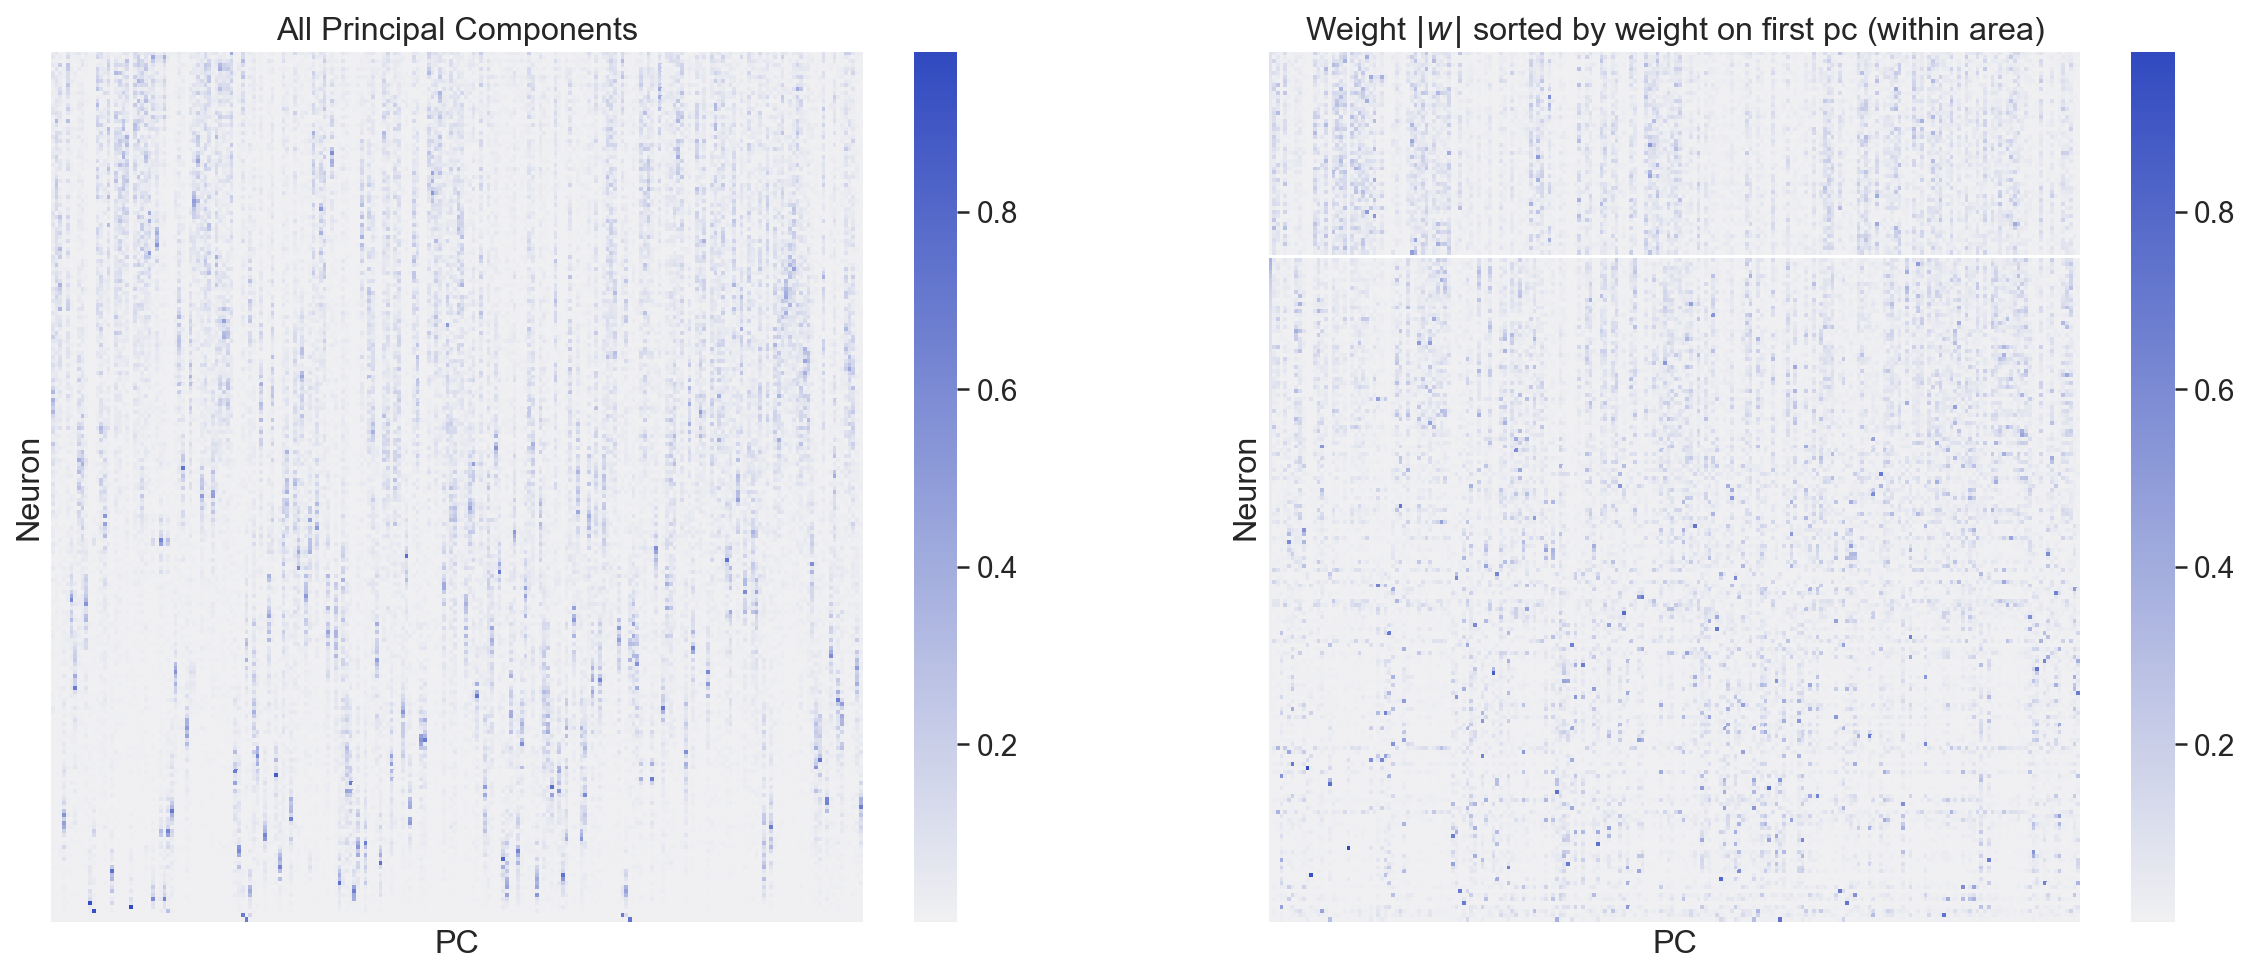

In [82]:
PCs_sorted = sort_pcs(PCs=model_m1pmd.components_, end_M1=td['M1_spikes'][0].shape[1], dim=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(abs(model_m1pmd.components_), cbar=True, ax=ax1, cmap=cmap, xticklabels=False, yticklabels=False)
ax1.set_title('All Principal Components')
ax1.set_xlabel('PC')
ax1.set_ylabel('Neuron')

sns.heatmap(abs(PCs_sorted), cbar=True, ax=ax2, cmap=cmap, xticklabels=False, yticklabels=False)
ax2.set_title(r'Weight $|w|$ sorted by weight on first pc (within area)')
ax2.set_xlabel('PC')
ax2.set_ylabel('Neuron');

### 2.2 Perform PCA on M1 array

In [83]:
pca_dims_m1 = td.M1_rates[0].shape[1]

# perform dimensionality reduction on all trialdata
td, model_m1 = tools.dim_reduce(td, PCA(pca_dims_m1), 'M1_rates', 'M1_pca', return_model=True)

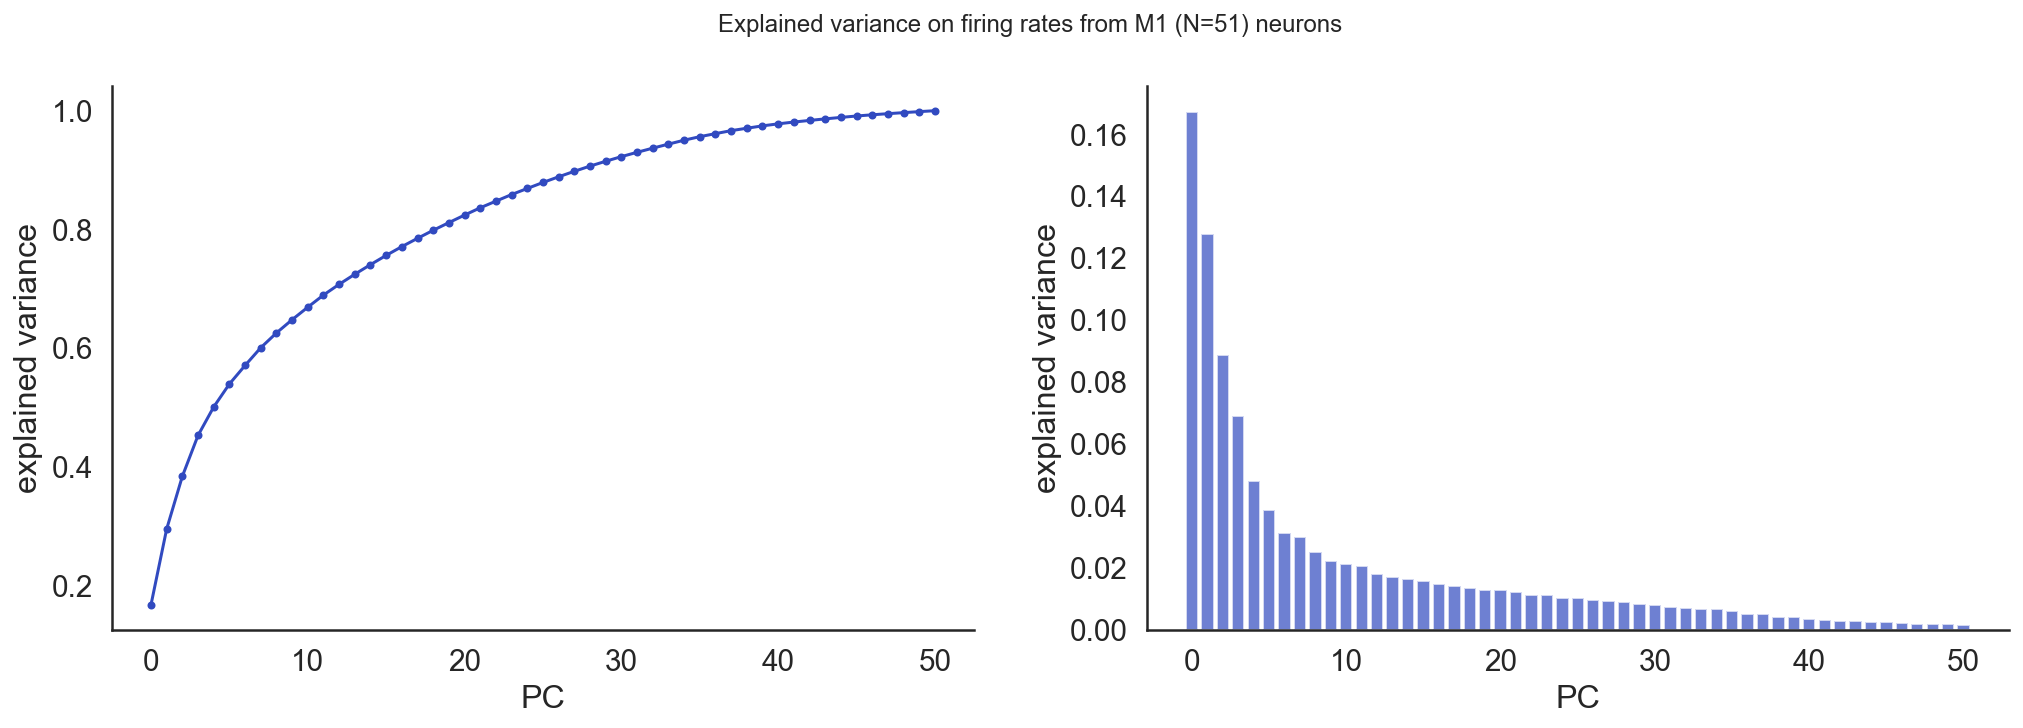

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
fig.suptitle(f'Explained variance on firing rates from M1 (N={td.M1_rates[0].shape[1]}) neurons')
ax1.plot(model_m1.explained_variance_ratio_.cumsum(), '.-')
ax1.set_xlabel('PC')
ax1.set_ylabel('explained variance')

ax2.bar(range(len(model_m1.explained_variance_ratio_)), model_m1.explained_variance_ratio_, alpha=0.7, align='center')
ax2.set_xlabel('PC')
ax2.set_ylabel('explained variance')
sns.despine()

### 2.3 Perform PCA on PMd array

In [85]:
pca_dims_pmd = td.PMd_rates[0].shape[1]

# perform dimensionality reduction on all trialdata
td, model_pmd = tools.dim_reduce(td, PCA(pca_dims_pmd), 'PMd_rates', 'PMd_pca', return_model=True)

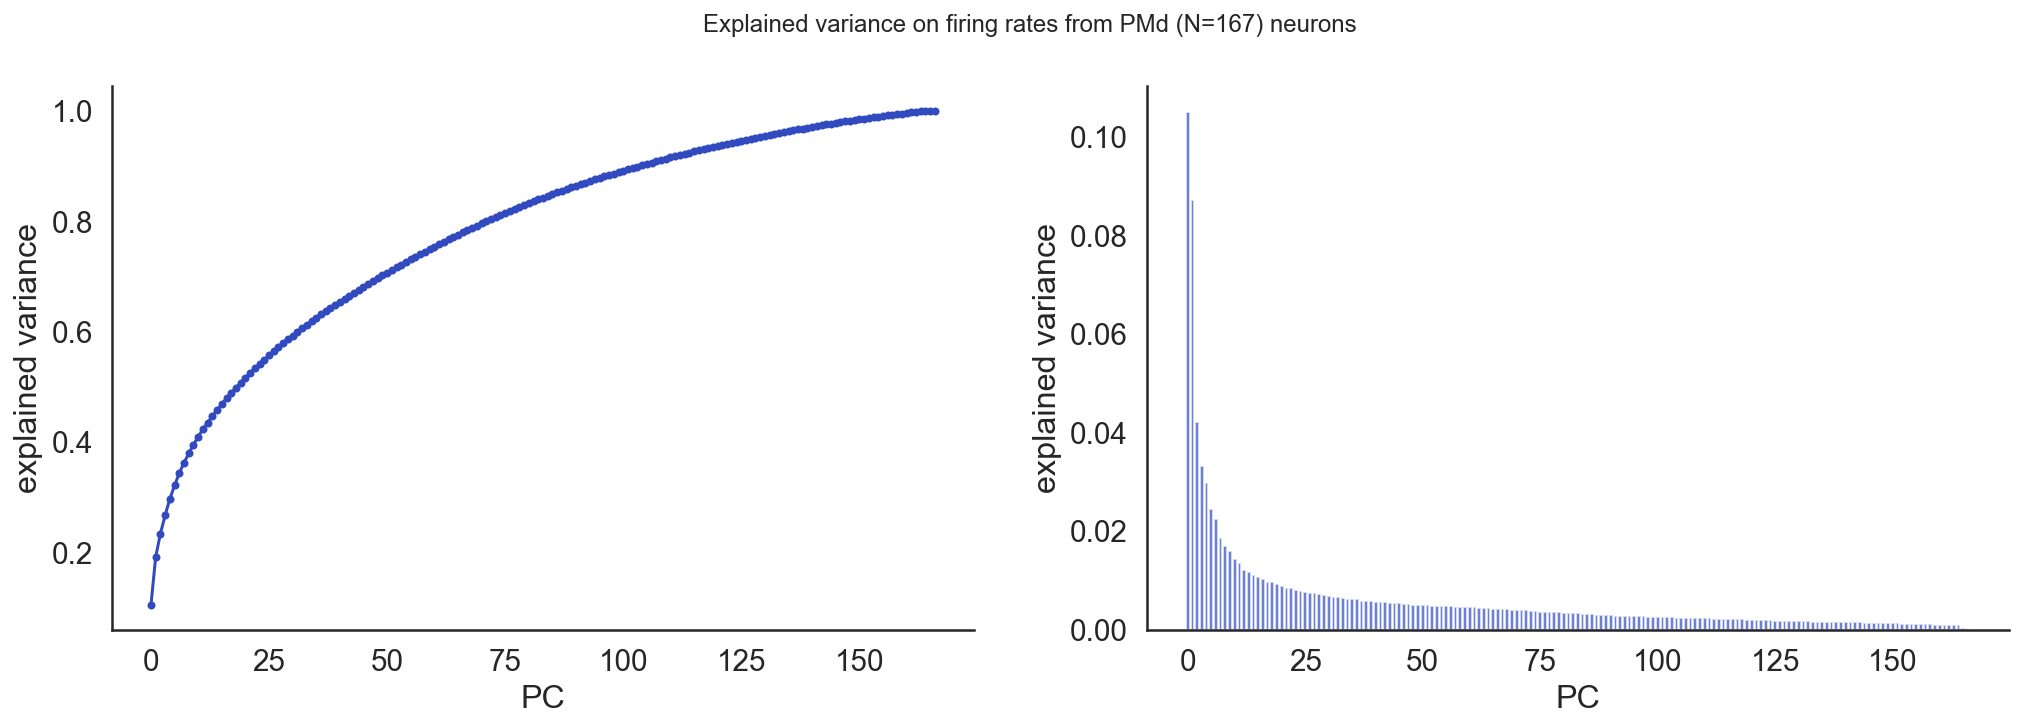

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
fig.suptitle(f'Explained variance on firing rates from PMd (N={td.PMd_rates[0].shape[1]}) neurons')
ax1.plot(model_pmd.explained_variance_ratio_.cumsum(), '.-')
ax1.set_xlabel('PC')
ax1.set_ylabel('explained variance')

ax2.bar(range(len(model_pmd.explained_variance_ratio_)), model_pmd.explained_variance_ratio_, alpha=0.7, align='center')
ax2.set_xlabel('PC')
ax2.set_ylabel('explained variance')
sns.despine()

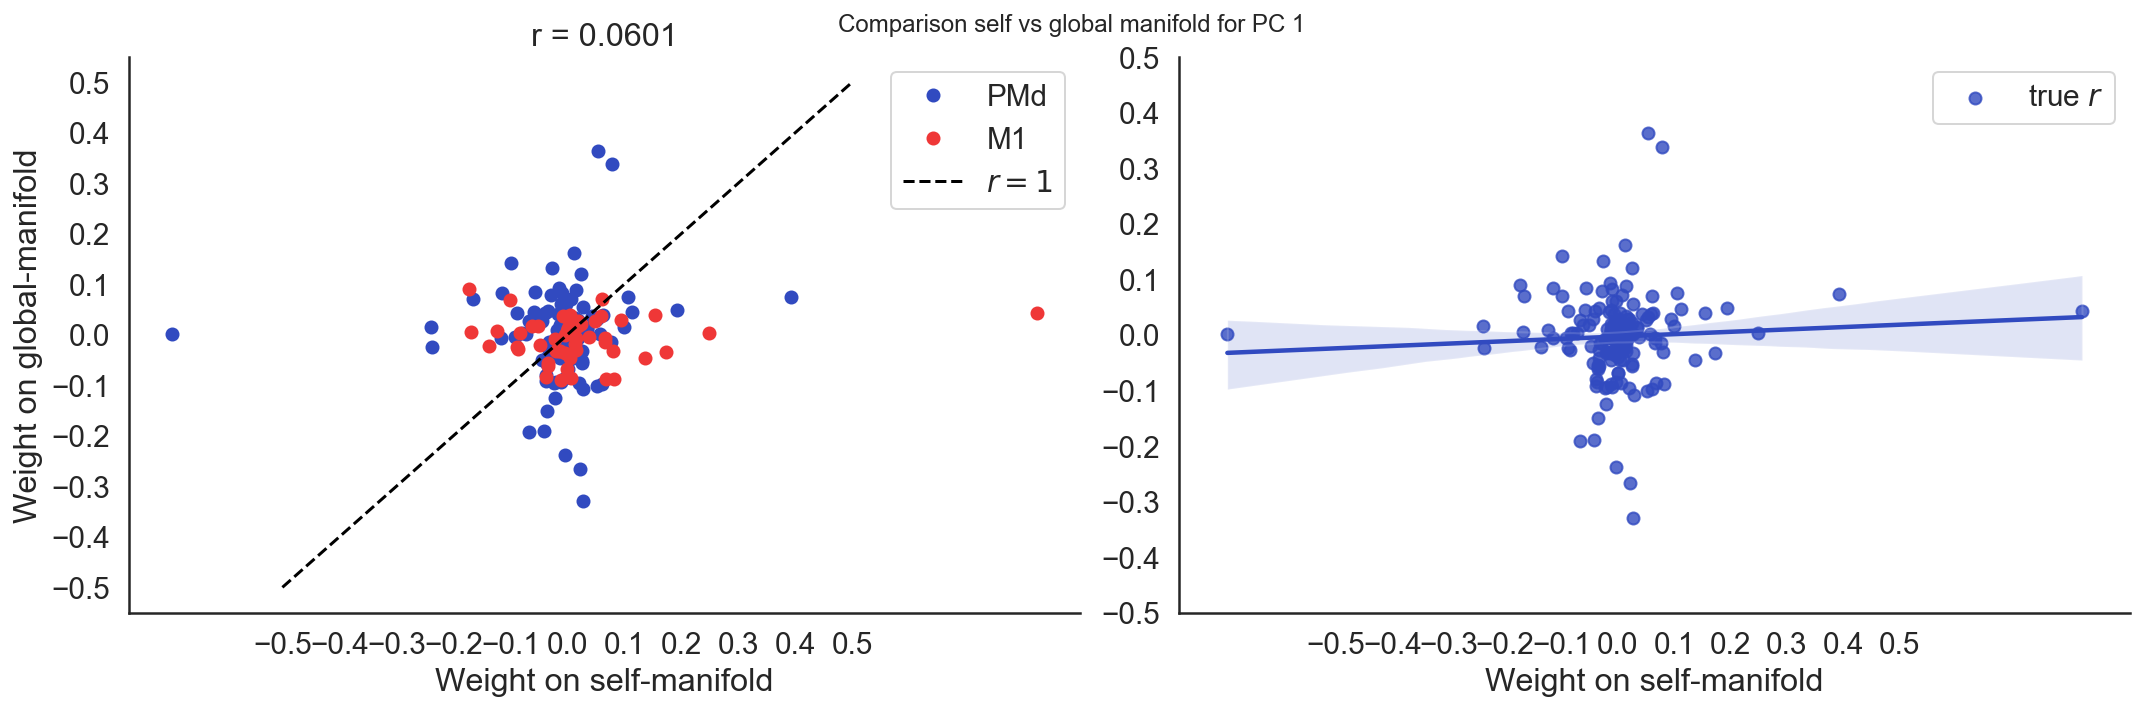

In [87]:
compare_self_global_mani(model_m1.components_, model_pmd.components_, model_m1pmd.components_, end_M1=td.M1_spikes[0].shape[1], pc_dim=0)

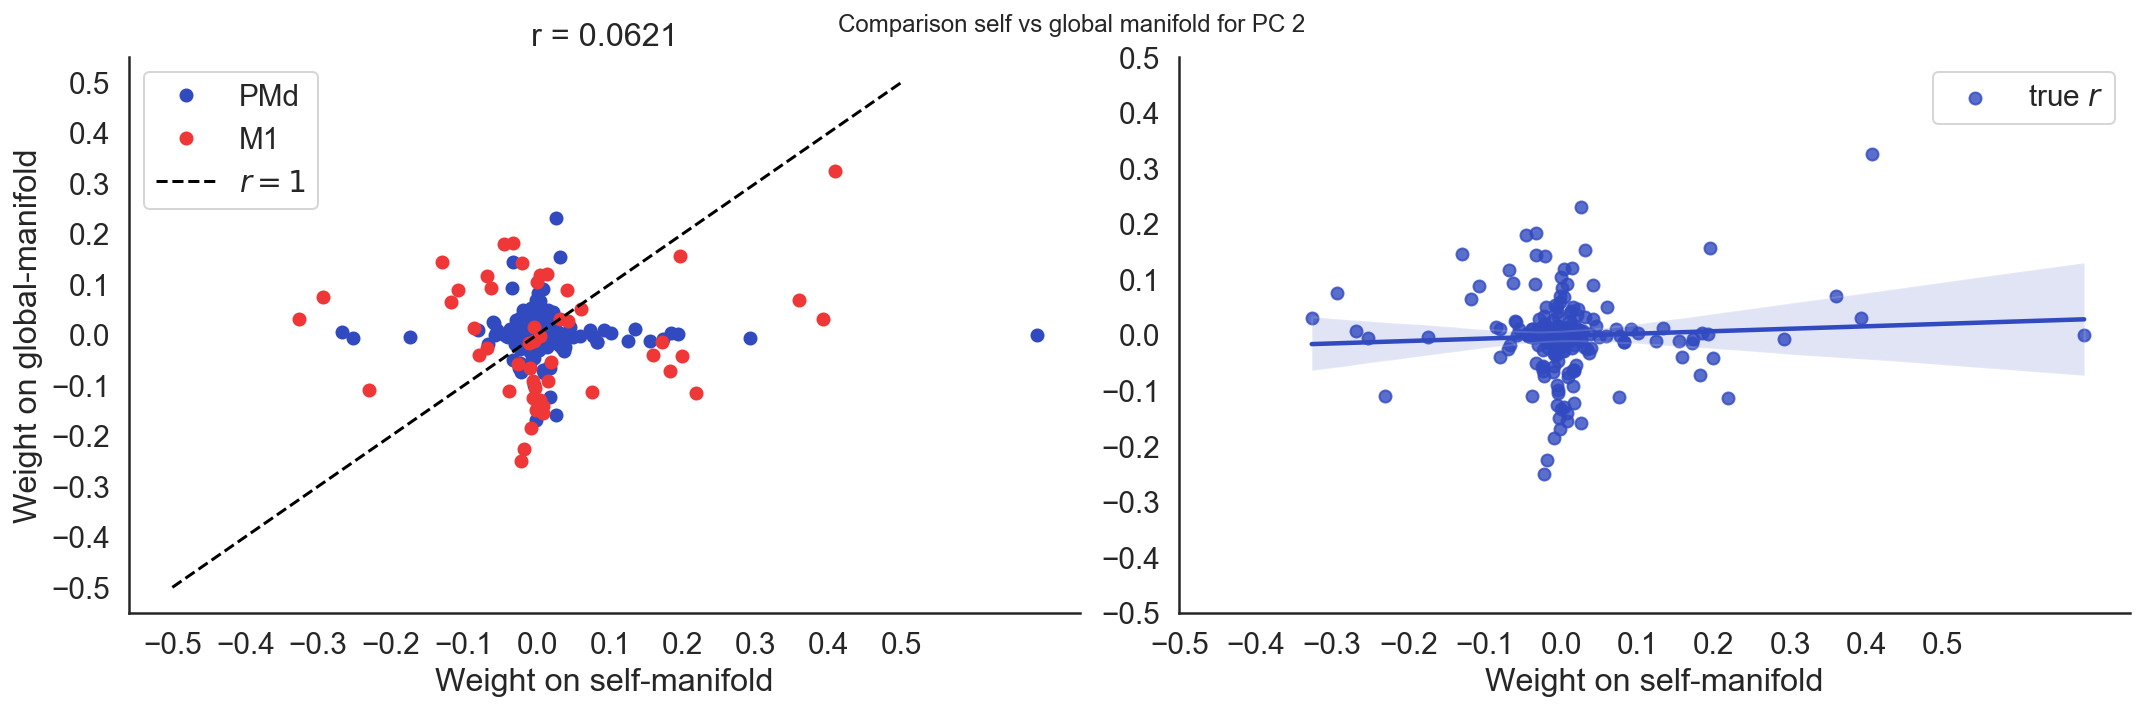

In [88]:
compare_self_global_mani(model_m1.components_, model_pmd.components_, model_m1pmd.components_, end_M1=td.M1_spikes[0].shape[1], pc_dim=1)

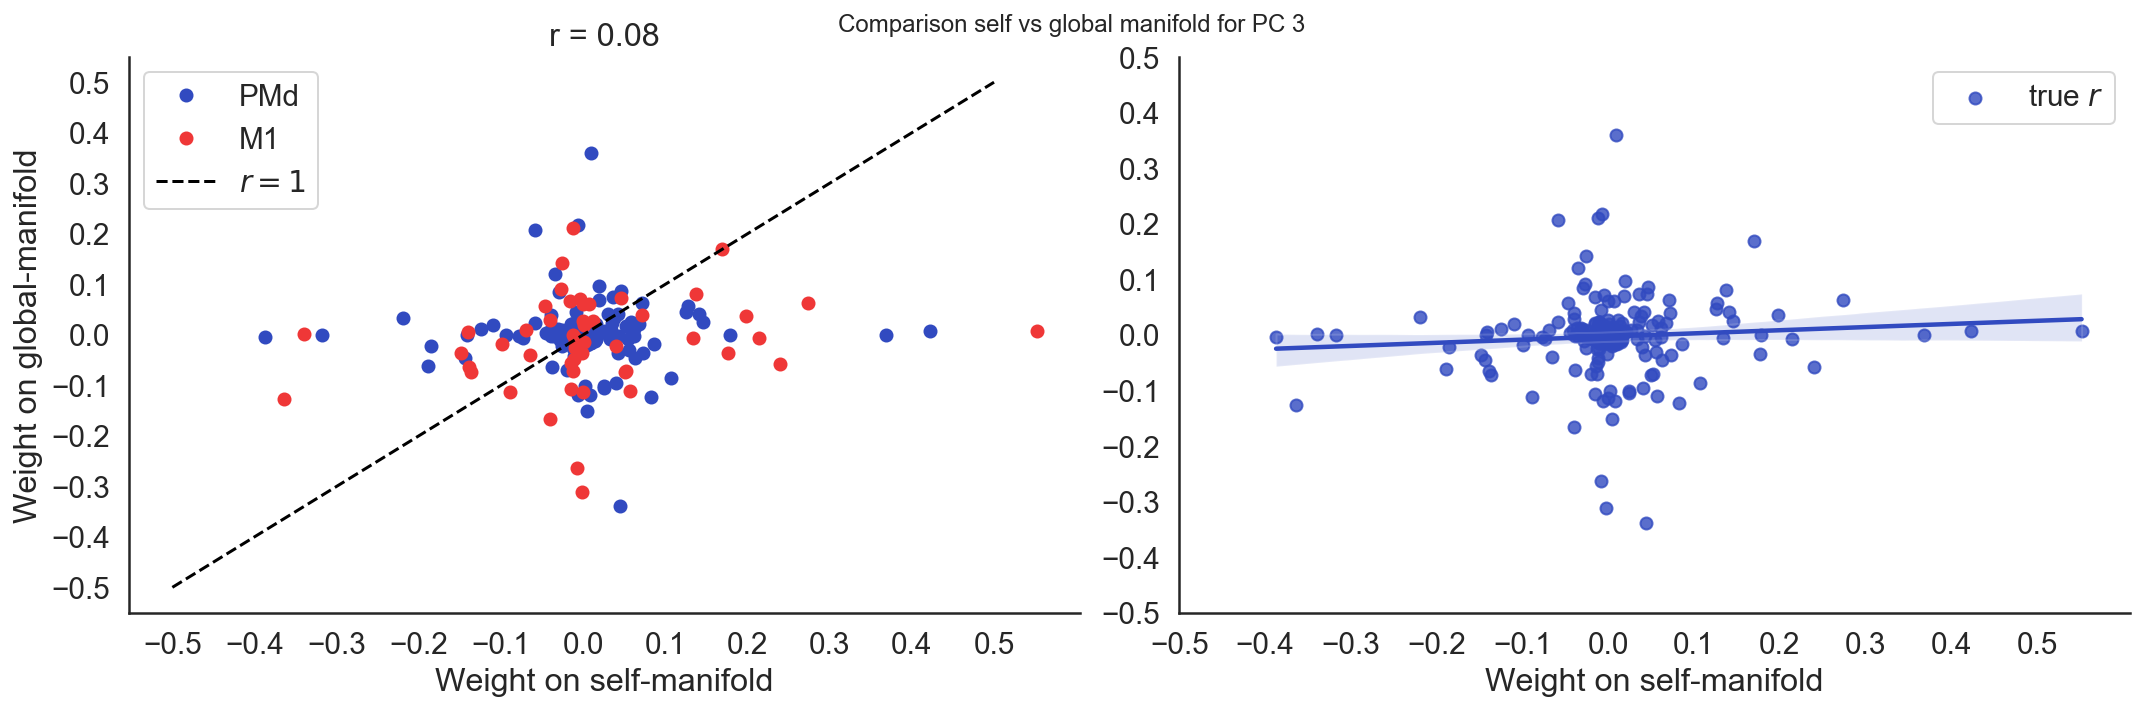

In [89]:
compare_self_global_mani(model_m1.components_, model_pmd.components_, model_m1pmd.components_, end_M1=td.M1_spikes[0].shape[1], pc_dim=2)

In [ ]:
# # concatenate all 
# X = np.concatenate(td['both_rates'].values, axis=0)
# pca = decomposition.PCA()
# X = pca.fit_transform(X)